# Cloud Storage buckets image and video processing pipelines

In [1]:
import pandas as pd
from IPython.display import clear_output as co

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Google Cloud Storage wrapper module

In [2]:
from modules.googlecloudstorage import GCS

sa_json = '../../../../Apps/Python/cams-rio/auth/octacity-iduff.json' # 'auth/pluvia-sa.json'
user_project = 'octacity'
default_bucket_name = 'city-camera-images'

gcs = GCS(sa_json, user_project, default_bucket_name)

#### Image classification settings - Histogram max. percentage

In [3]:
from modules.histogram import HistogramClassifier

threshold=0.6
clf_hist = HistogramClassifier(threshold)
skipper = clf_hist.is_histogram_clustered

#### Python module: Controlled pipeline execution (pandas dataframe based)

In [4]:
from modules.controlled_pipeline import ControlledPipeline

---
## Clean up storage

#### Delete blobs that match provided extension

In [77]:
bucket_name = 'flood-video-collection'
prefix = 'rain/'
delimiter = None

ext = '.mp4.mp4'

blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

blobs_ext = []
for blob_name in blobs:
    
    if blob_name.endswith(ext):
        blobs_ext.append(blob_name)

print('Blobs:', len(blobs), '· Query:', len(blobs_ext))

bucket = gcs.get_bucket(bucket_name)

deleted = 0
for i, blob in enumerate(bucket.list_blobs(prefix=prefix, delimiter=delimiter)):

    if blob.name.endswith(ext):
        blob.delete(); deleted += 1

    co(True); print(f'Iteration: {i+1}/{len(blobs)} · Deleted: {deleted}/{len(blobs_ext)}')

Iteration: 18/18 · Deleted: 0/0


#### Check result

In [66]:
blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

blobs_ext = []
for blob_name in blobs:
    if blob_name.endswith(ext): blobs_ext.append(blob_name)
#     if len(blob_name.split(pattern)) - 1 == 2: blobs_ext.append(blob_name)

print(f'Blobs: {len(blobs)} · Query: {len(blobs_ext)}')

Blobs: 577 · Query: 0


---
## Delete images in cloud storage bucket based on image classification result

#### List blobs in blob

In [29]:
bucket_name = 'city-camera-images'
prefix = ''
delimiter = None
ext = '.jpg'

drop_first = False
print_each = 1000

blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

names = []
for i, blob in enumerate(blobs):
    if blob.name.endswith(ext): names.append(blob.name)
    if (i + 1) % print_each == 0: print(f'\n- Blobs Searched: {i + 1}'); co(True)

print(f'\n- Blobs Searched: {i + 1}')
if drop_first: print(f'\n · First item excluded: {names[0]}'); del names[0]
print(f'\n · Results: {len(names)}')

#### Build and save blobs control dataset

In [32]:
control = pd.DataFrame(names, columns=['blob_name'])

control['bucket_name'] = 'city-camera-images'
control['status'] = 'UNKNOWN' # special control field

data_path = '../../../Data Science Projects/Hackaton COR IV - Centro de Operações do RJ/INCUBAÇÃO/Cameras/Dados'
control_path = f'{data_path}/blobs/images_control.csv'

control.to_csv(control_path, index=False)

#### Function: Delete dark images · status control managed locally

In [5]:
import cv2, numpy as np

def load_image_from_bytes(bytes_string):
    return cv2.imdecode(np.frombuffer(bytes_string, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

def delete_blob_if_invalid(blob_name, bucket_name):
    blob = gcs.get_blob(blob_name, bucket_name) # get blob
    image_bytes = blob.download_as_string()
    status = image_bytes == b'' or clf_hist.is_histogram_clustered(load_image_from_bytes(image_bytes))
    if status: blob.delete()
    return status

#### Test control function

In [11]:
bucket_name = 'city-camera-images'
blob_name = 'rain/1020/2023-02-10 17:55:01/CODE1020_2023-02-10 18:04:59.jpg'

delete_blob_if_invalid(blob_name, bucket_name)

True

#### Pipeline: Delete invalid blobs using control dataset

In [17]:
save_each = 1000
report_each = 100

control_path = f'Dados/blobs/images_control.csv'

control_func = delete_blob_if_invalid
params_fields = ['blob_name', 'bucket_name']
status_field = 'status'
query = {'status': ['ERROR']} #, 'UPLOAD_FAILED']}
status_options = ['VALID', 'DELETED']
error_flag = 'ERROR'

pipe = ControlledPipeline(
    control_path, control_func, params_fields,
    query, status_field, status_options, error_flag,
)

pipe.run(report_each, save_each)


- PROGRESS: 0 / 1 ops · PROGRESS-PRCT: 0.0 %

- TOTAL: 626601 / 626602 ops · TOTAL-PRCT: 100.0 %

* EXCEPTION: 404 GET https://storage.googleapis.com/download/storage/v1/b/city-camera-images/o/rain%2F1020%2F2023-02-10%2017%3A55%3A01%2FCODE1020_2023-02-10%2018%3A04%3A59.jpg?alt=media&userProject=octacity: No such object: city-camera-images/rain/1020/2023-02-10 17:55:01/CODE1020_2023-02-10 18:04:59.jpg: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>) · UPDATE-STATUS: ERROR

- PROGRESS: 0 / 1 ops · PROGRESS-PRCT: 0.0 %

- TOTAL: 626601 / 626602 ops · TOTAL-PRCT: 100.0 %

* BLOBS CONTROL UPDATE SUCCESSFUL!


#### Reload blobs control · Check result

In [18]:
import pandas as pd

control_path = f'Dados/blobs/images_control.csv'

folders = pd.read_csv(control_path)

folders['status'].value_counts()

VALID      491834
DELETED    134767
ERROR           1
Name: status, dtype: int64

---
## Delete empty folders in bucket

#### List blobs in blob

In [11]:
bucket_name = 'city-camera-images'
prefix = '' # search all blobs
delimiter = None
ext = '/'

drop_first = False
print_each = 1000

blobs = gcs.list_blobs(prefix, delimiter, bucket_name)

names = []
for i, blob in enumerate(blobs):
    if blob.name.endswith(ext): names.append(blob.name)
    if (i + 1) % print_each == 0: print(f'\n- Blobs Searched: {i + 1}'); co(True)

print(f'\n- Blobs Searched: {i + 1}')
if drop_first: print(f'\n · First item excluded: {names[0]}'); del names[0]
print(f'\n · Results: {len(names)}')

drop_if_exists = ['pics/', 'flood/', 'rain/', 'comando/', 'waze/']

if len(drop_if_exists):
    for name in drop_if_exists:
        if name in names:
            print(f'\n- BLOB: {name} (excluded)')
            del names[names.index(name)]


- Blobs Searched: 514863

 · Results: 15324
BLOB pics/ excluded.


#### Build and save blobs control dataset

In [17]:
control = pd.DataFrame(names, columns=['folder'])

control['bucket_name'] = None # bucket_name
control['status'] = 'UNKNOWN' # special control field

control_path = f'Dados/blobs/empty_folder_control_2.csv'

# control.to_csv(control_path, index=False)

#### Python function: Delete folder if empty

In [8]:
def delete_folder_if_empty(folder, bucket_name): # ignores non-existing folders
    i = None
    for i, blob in enumerate(gcs.list_blobs(prefix=folder, bucket_name=bucket_name)):
        if i == 1: return False
    if i is None:
        print(f'FOLDER NOT FOUND · FOLDER: {folder} · BUCKET: {bucket_name}');
        return False
    blob.delete()
    print(f'\n* FOLDER EMPTY: DELETED · FOLDER: {folder} · BUCKET: {bucket_name}')
    return True

#### Test control function

In [9]:
bucket_name = float('nan') # 'city-camera-images'
folder = 'test/pics/1020/2023-02-08 09:55:00/'

delete_folder_if_empty(folder, bucket_name)

FOLDER NOT FOUND · FOLDER: test/pics/1020/2023-02-08 09:55:00/ · BUCKET: nan


False

#### Run pipeline: delete empty folders using control dataset

In [16]:
save_each = 1000
report_each = 100

control_path = f'Dados/blobs/empty_folder_control_2.csv'

control_func = delete_folder_if_empty
params_fields = ['folder', 'bucket_name']
query = {'status': ['UNKNOWN']} #, 'UPLOAD_FAILED']}
status_field = 'status'
status_options = ['VALID', 'DELETED']
error_flag = 'ERROR'

pipe = ControlledPipeline(
    control_path, control_func, params_fields,
    query, status_field, status_options, error_flag,
)

pipe.run(report_each, save_each)


- PROGRESS: 6800 / 6890 ops · PROGRESS-PRCT: 98.7 %

- TOTAL: 15233 / 15323 ops · TOTAL-PRCT: 99.4 %

- RUNNING: 7.4 min · EXPECT-FINISH: 0.1 min · RATE: 15.3635 ops / s

- PROGRESS: 6889 / 6890 ops · PROGRESS-PRCT: 100.0 %

- TOTAL: 15322 / 15323 ops · TOTAL-PRCT: 100.0 %

- RUNNING: 7.5 min · EXPECT-FINISH: 0.0 min · RATE: 15.3691 ops / s

* BLOBS CONTROL UPDATE SUCCESSFUL!


#### Reload control dataset

In [17]:
control_path = f'Dados/blobs/empty_folder_control_2.csv'
control = pd.read_csv(control_path)

control['status'].value_counts()

VALID      15322
DELETED        1
Name: status, dtype: int64

In [18]:
control[control['status']=='DELETED']

,folder,bucket_name,status
0,flood/1083/2023-02-10 18:10:00/,NaN,DELETED


In [ ]:
import requests
from urllib.parse import urlencode

query = {
    'folder': 'manual/2023-08-02/1119/2023-02-08 15:55:00/',
    'to_blob_name': 'test/TEST.mp4',
    'from_bucket_name': 'city-camera-images',
    'to_bucket_name': 'city-camera-images', # 'flood-video-collection'
    'ext': '.jpg',
    'content_type': 'video/mp4',
    'overwrite': True,
    'report': False,
}

baseurl = 'http://127.0.0.1:5001'

url = f'{baseurl}/write-video?{urlencode(query)}'

res = requests.get(url, params=query)

print(res.status_code, res.reason, res.json())

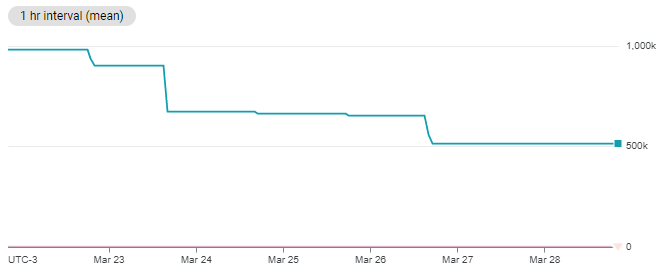